## Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ast import literal_eval

## Perform EDA

In [ ]:
arxiv_data = pd.read_csv(
    'https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv'
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [ ]:
print('There are {} registers in the dataset'.format(len(arxiv_data)))

There are 51774 registers in the dataset


In [ ]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print('There are {} duplicated titles'.format(total_duplicate_titles))

There are 12802 duplicated titles


In [ ]:
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [ ]:
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]
print('There are {} registers in the deduplicated dataset'.format(len(arxiv_data)))

There are 38972 registers in the deduplicated dataset


In [ ]:
arxiv_data["terms"].value_counts()

['cs.CV']                                          12747
['cs.LG', 'stat.ML']                                4074
['cs.LG']                                           2046
['cs.CV', 'cs.LG']                                  1486
['cs.LG', 'cs.AI']                                  1206
                                                   ...  
['cs.LG', 'cs.CL', 'cs.HC', 'stat.ML']                 1
['cs.LG', 'cs.AI', 'cs.CL', 'cs.PL', 'stat.ML']        1
['cs.LG', 'cs.CL', 'stat.ME', 'stat.ML']               1
['cs.LG', 'cs.CL', 'cs.LO', 'stat.ML']                 1
['stat.ML', 'cs.CV', 'cs.LG', 'q-bio.QM']              1
Name: terms, Length: 3157, dtype: int64

In [ ]:
print(sum(arxiv_data["terms"].value_counts() == 1))

2321


In [ ]:
print(arxiv_data["terms"].nunique())

3157


In [ ]:
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

In [ ]:
arxiv_data_filtered.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [ ]:
arxiv_data_filtered["terms"].value_counts()

['cs.CV']                                                         12747
['cs.LG', 'stat.ML']                                               4074
['cs.LG']                                                          2046
['cs.CV', 'cs.LG']                                                 1486
['cs.LG', 'cs.AI']                                                 1206
                                                                  ...  
['cs.CV', 'cs.LG', 'eess.IV', 'eess.SP', 'stat.ML']                   2
['cs.LG', 'cs.CL', 'cs.CV', 'cs.NE', 'stat.ML']                       2
['stat.ML', 'cs.IT', 'cs.LG', 'math.IT', 'math.ST', 'stat.TH']        2
['cs.CV', 'cs.CL', 'cs.LG', 'eess.AS', 'eess.IV']                     2
['cs.LG', 'G.3']                                                      2
Name: terms, Length: 836, dtype: int64

## Convert the string labels to lists of strings

In [ ]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(lambda x: literal_eval(x))
arxiv_data_filtered["terms"]

0                    [cs.CV, cs.LG]
1             [cs.CV, cs.AI, cs.LG]
2                    [cs.CV, cs.AI]
3                           [cs.CV]
4                    [cs.CV, cs.LG]
                    ...            
51767                       [cs.CV]
51768                       [cs.CV]
51770                [cs.CV, cs.DM]
51771    [stat.ML, cs.LG, q-bio.GN]
51772                       [cs.CV]
Name: terms, Length: 36651, dtype: object

## Use stratified splits because of class imbalance

In [ ]:
test_split = 0.1

train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify = arxiv_data_filtered['terms'].values
)

val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print('Number of registers in train set: {}'.format(len(train_df)))
print('Number of registers in val set: {}'.format(len(val_df)))
print('Number of registers in test set: {}'.format(len(test_df)))

Number of registers in train set: 32985
Number of registers in val set: 1833
Number of registers in test set: 1833


In [ ]:
terms = tf.ragged.constant(train_df['terms'].values)
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
lookup.adapt(terms)

In [ ]:
vocab = lookup.get_vocabulary()

In [ ]:
print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.SE', 'cs.CG', 'cs.NI', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cs.PL', 'cond-mat.dis-nn', '68T45', 'math.PR', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', 'math.DS', '68T05', 'quant-ph', 'physics.data-an', 'cs.CC', 'I.4.6', 'physics.soc-ph', 'physics.ao-ph', 'q-bio.GN', 'econ.EM', 'cs.DM', 'physics.med-ph', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.PF', 'I.4', 'q-fin.TR', 'cs.FL', 'I.5.4', 'I.2', '68U10', 'hep-ex', '68T10', 'physics.optics', 'physics.geo-ph', 'cond-mat.mtrl-sci', 'q-fin.CP', 'physics.flu-dyn', 'math.CO', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6

In [ ]:
def invert_multi_hot(encoded_labels):
  """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
  hot_indices = np.argwhere(encoded_labels==1.0)[..., 0]
  return np.take(vocab, hot_indices)

In [ ]:
sample_label = train_df["terms"].iloc[0]
print('Original label:', sample_label)

Original label: ['cs.LG', 'cs.AI', 'stat.ML']


In [ ]:
label_binarized = lookup([sample_label])
print('Label binarized:', label_binarized)

Label binarized: tf.Tensor(
[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 153), dtype=float32)


In [ ]:
train_df['summaries'].apply(lambda x: len(x.split())).describe()

count    32985.000000
mean       171.520994
std         45.410933
min          5.000000
25%        140.000000
50%        169.000000
75%        201.000000
max        326.000000
Name: summaries, dtype: float64

In [ ]:
# train
text_train = list(train_df['summaries'])
y_train = lookup(tf.ragged.constant(train_df["terms"].values)).numpy()

# validation
text_val = list(val_df['summaries'])
y_val = lookup(tf.ragged.constant(val_df["terms"].values)).numpy()

# test
text_test = list(test_df['summaries'])
y_test = lookup(tf.ragged.constant(test_df["terms"].values)).numpy()

In [ ]:
maxlen = 150
batch_size = 128
max_words = 10000 # considers only the top 10000 words in dataset

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text_train)
sequences_train = tokenizer.texts_to_sequences(text_train)

In [ ]:
print(len(sequences_train))
print(len(sequences_train[0]))
print(sequences_train[0])

32985
163
[127, 14, 102, 24, 45, 563, 1165, 6, 32, 77, 35, 2631, 13, 60, 376, 4459, 6, 12, 39, 7, 520, 185, 12, 2926, 2150, 203, 110, 1, 506, 8, 4, 329, 2150, 500, 11, 283, 105, 234, 376, 4459, 6, 306, 7, 214, 967, 40, 8, 136, 4, 520, 5, 90, 3213, 2, 2150, 500, 277, 1011, 2, 3831, 8271, 51, 557, 40, 8, 136, 4, 797, 9, 178, 2, 942, 42, 16, 41, 9, 12, 7, 456, 1, 3983, 376, 297, 3, 680, 203, 102, 1, 1665, 55, 13, 3, 158, 7, 514, 58, 4, 707, 1, 81, 10, 1, 6956, 2912, 65, 3, 1, 5155, 5936, 9395, 317, 65, 7, 84, 11, 1011, 263, 6003, 1754, 1, 203, 3, 11, 3492, 397, 496, 74, 645, 6, 1065, 2150, 500, 11, 283, 136, 234, 376, 4459, 21, 17, 78, 7, 2392, 11, 680, 203, 13, 5, 347, 238, 1773, 149, 8, 1, 300, 1396, 9, 2150, 203, 6, 127, 14, 62]


In [ ]:
word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))

Found 55628 unique tokens


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(text_train), maxlen=maxlen, padding='post', truncating='post')
x_val = pad_sequences(tokenizer.texts_to_sequences(text_val), maxlen=maxlen, padding='post', truncating='post')
x_test = pad_sequences(tokenizer.texts_to_sequences(text_test), maxlen=maxlen, padding='post', truncating='post')

In [ ]:
print(len(x_train[0]))
print(x_train[0])

150
[ 127   14  102   24   45  563 1165    6   32   77   35 2631   13   60
  376 4459    6   12   39    7  520  185   12 2926 2150  203  110    1
  506    8    4  329 2150  500   11  283  105  234  376 4459    6  306
    7  214  967   40    8  136    4  520    5   90 3213    2 2150  500
  277 1011    2 3831 8271   51  557   40    8  136    4  797    9  178
    2  942   42   16   41    9   12    7  456    1 3983  376  297    3
  680  203  102    1 1665   55   13    3  158    7  514   58    4  707
    1   81   10    1 6956 2912   65    3    1 5155 5936 9395  317   65
    7   84   11 1011  263 6003 1754    1  203    3   11 3492  397  496
   74  645    6 1065 2150  500   11  283  136  234  376 4459   21   17
   78    7 2392   11  680  203   13    5  347  238]


In [ ]:
print('Shape of data_train tensor:', x_train.shape)
print('Shape of labels_train tensor:', y_train.shape)
print()
print('Shape of data_val tensor:', x_val.shape)
print('Shape of labels_val tensor:', y_val.shape)
print()
print('Shape of data_test tensor:', x_test.shape)
print('Shape of labels_test tensor:', y_test.shape)

Shape of data_train tensor: (32985, 150)
Shape of labels_train tensor: (32985, 153)

Shape of data_val tensor: (1833, 150)
Shape of labels_val tensor: (1833, 153)

Shape of data_test tensor: (1833, 150)
Shape of labels_test tensor: (1833, 153)


## GloVe embedding

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-12-09 22:44:19--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-09 22:44:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2022-12-09 22:46:59 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [ ]:
embeddings_index = {}

f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found {} word vectors'.format(len(embeddings_index)))

Found 400000 word vectors


In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

## Model

In [ ]:
model = keras.models.Sequential([
    layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    layers.Bidirectional(layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 153)               9945      
                                                                 
Total params: 1,102,681
Trainable params: 1,102,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 153)               9945      
                                                                 
Total params: 1,102,681
Trainable params: 102,681
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=3,
    monitor='val_loss',
    min_delta=0.001,
    mode='min',
    verbose=1,
    restore_best_weights=True,
)

Epoch 1/20
258/258 [==============================] - 155s 579ms/step - loss: 0.0704 - categorical_accuracy: 0.4925 - val_loss: 0.0269 - val_categorical_accuracy: 0.5434
Epoch 2/20
258/258 [==============================] - 143s 556ms/step - loss: 0.0256 - categorical_accuracy: 0.7003 - val_loss: 0.0214 - val_categorical_accuracy: 0.8794
Epoch 3/20
258/258 [==============================] - 144s 558ms/step - loss: 0.0218 - categorical_accuracy: 0.8717 - val_loss: 0.0206 - val_categorical_accuracy: 0.8773
Epoch 4/20
258/258 [==============================] - 146s 567ms/step - loss: 0.0212 - categorical_accuracy: 0.8792 - val_loss: 0.0203 - val_categorical_accuracy: 0.8849
Epoch 5/20
258/258 [==============================] - 136s 525ms/step - loss: 0.0209 - categorical_accuracy: 0.8842 - val_loss: 0.0203 - val_categorical_accuracy: 0.8712
Epoch 6/20
258/258 [==============================] - 156s 604ms/step - loss: 0.0206 - categorical_accuracy: 0.8871 - val_loss: 0.0200 - val_categoric

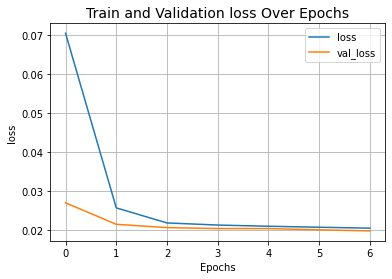

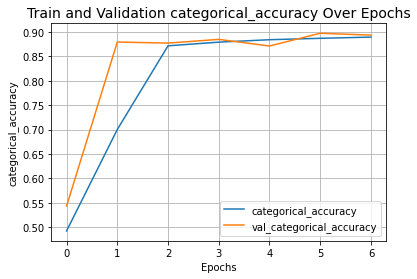

In [ ]:
epochs = 20

model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)


def plot_result(item):
  plt.plot(history.history[item], label=item)
  plt.plot(history.history["val_" + item], label="val_" + item)
  plt.xlabel("Epochs")
  plt.ylabel(item)
  plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
  plt.legend()
  plt.grid()
  plt.show()

plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = model.evaluate(x_val, y_val)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

58/58 [==============================] - 3s 46ms/step - loss: 0.0203 - categorical_accuracy: 0.8849
Categorical accuracy on the test set: 88.49%.


## Inference

In [ ]:
for text_, x_, label_ in zip(text_test[:5], x_test[:5], y_test[:5]):
  print(f"Abstract: {text_}")
  print(f"Label(s): {invert_multi_hot(label_)}")
  predicted_probabilities = model.predict(x_[np.newaxis, ...])
  predicted_proba = [proba for proba in predicted_probabilities[0]]
  top_3_labels = {}
  for score, x in sorted(zip(predicted_probabilities[0], lookup.get_vocabulary()), key=lambda pair: pair[0], reverse=True)[:3]:
    top_3_labels[x] = round(score, 3)
  print(top_3_labels)
  print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
  print(" ")

Abstract: Recent neural view synthesis methods have achieved impressive quality and
realism, surpassing classical pipelines which rely on multi-view
reconstruction. State-of-the-Art methods, such as NeRF, are designed to learn a
single scene with a neural network and require dense multi-view inputs. Testing
on a new scene requires re-training from scratch, which takes 2-3 days. In this
work, we introduce Stereo Radiance Fields (SRF), a neural view synthesis
approach that is trained end-to-end, generalizes to new scenes, and requires
only sparse views at test time. The core idea is a neural architecture inspired
by classical multi-view stereo methods, which estimates surface points by
finding similar image regions in stereo images. In SRF, we predict color and
density for each 3D point given an encoding of its stereo correspondence in the
input images. The encoding is implicitly learned by an ensemble of pair-wise
similarities -- emulating classical stereo. Experiments show that SRF lea